In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from embeddings import get_embedding_matrix, sentence_to_indexes, MeanEmbedder
from emb_path import glove_6B_300d_path, lexvec_7B_300d_path
from gem import GEM
from scipy.stats import pearsonr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def read_sts(path):
    df = pd.read_csv(path, sep='\n', header=None, names=['row'])
    df = pd.DataFrame(df.row.str.split('\t', 6).tolist(), columns=['', 'genre','filename','year','score','sentence1','sentence2'])
    df.drop(df.columns[[0,1,2,3]], inplace=True, axis=1)
    df["score"] = pd.to_numeric(df["score"])
    return df

In [3]:
sts_dev = read_sts('data/sts_benchmark/sts-dev.csv')
sts_test = read_sts('data/sts_benchmark/sts-test.csv')

In [4]:
sts_dev.shape, sts_test.shape

((1500, 3), (1379, 3))

In [5]:
sts_test.head()

,score,sentence1,sentence2
0,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.5,A man is playing a harp.,A man is playing a keyboard.


In [6]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

def pred(ind, sim):
    n1 = sim.shape[0] // 2
    return sim[ind, n1+ind]

dfs = {"(sts-dev)": sts_dev,
       "(sts-test)": sts_test}
embds = {"Glove": get_embedding_matrix(glove_6B_300d_path),
         "LexVec": get_embedding_matrix(lexvec_7B_300d_path, islexvec=True)}
models = {"mean": MeanEmbedder, "GEM": GEM}

for df_name, df in dfs.items():
    for e_name, (e, v) in embds.items():
        sentences_inds = []
        for sent in df.sentence1.values.tolist():
            sentences_inds.append(sentence_to_indexes(sent, v))
        for sent in df.sentence2.values.tolist():
            sentences_inds.append(sentence_to_indexes(sent, v))
        for model_name, model in models.items():
            m = model(sentences_inds, e)
            result, s = m.get_sentence_embeddings()
            sim = cosine_similarity(result.T)
            df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
            corr = df.corr().iloc[0,1]
            print("{:>8} + {:<8} {:>10}: {:<10}".format(model_name, e_name, df_name, corr))

    mean + Glove     (sts-dev): 0.5180515345285918
     GEM + Glove     (sts-dev): 0.7987556139733658
    mean + LexVec    (sts-dev): 0.6659556237588711
     GEM + LexVec    (sts-dev): 0.7686247576058542
    mean + Glove    (sts-test): 0.27413319368302197
     GEM + Glove    (sts-test): 0.6487797277243852
    mean + LexVec   (sts-test): 0.38807813692042475
     GEM + LexVec   (sts-test): 0.6329578558722708
CPU times: user 4min 59s, sys: 4.2 s, total: 5min 3s
Wall time: 3min 8s


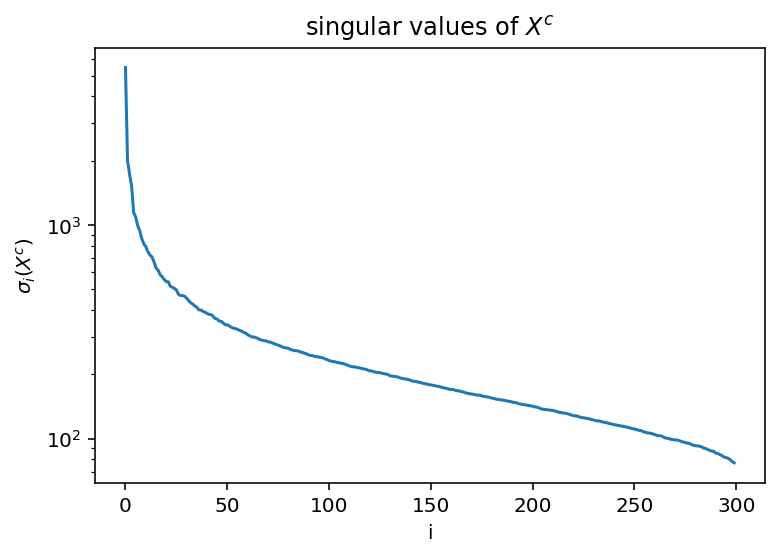

In [10]:
plt.plot(s)
plt.yscale('log')
plt.title(r'singular values of $X^c$')
plt.xlabel('i')
plt.ylabel(r'$\sigma_i(X^c)$')
plt.show()